Using device: cuda
Running main ANCCO-FL experiment...


/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


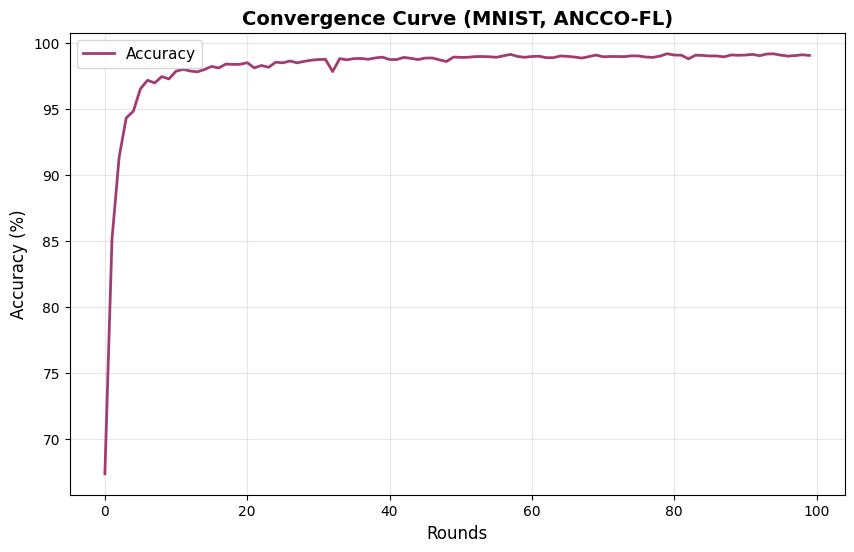

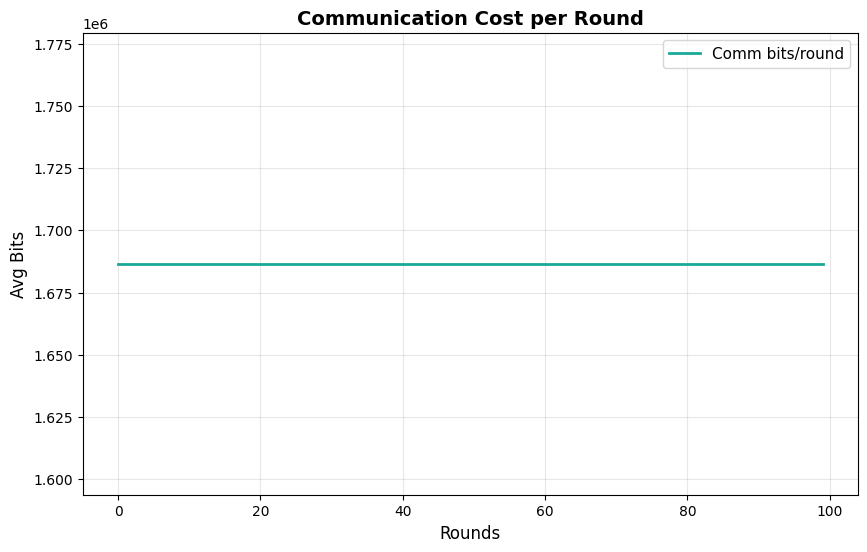


Running client dropout analysis...
Running dropout rate analysis...
Testing dropout rate: 0.0%
Testing dropout rate: 10.0%
Testing dropout rate: 20.0%
Testing dropout rate: 30.0%
Testing dropout rate: 40.0%
Testing dropout rate: 50.0%


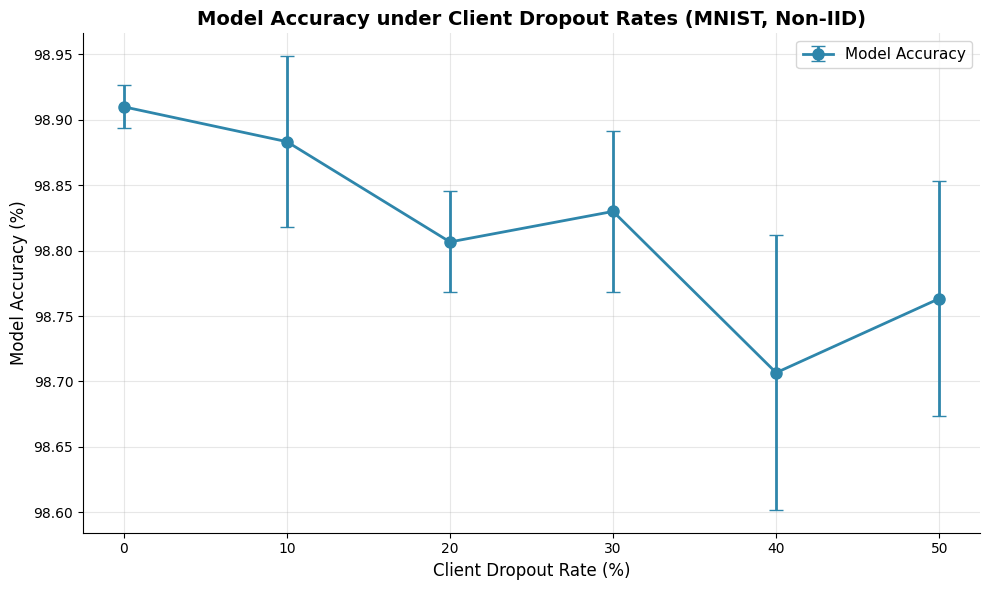


Dropout Analysis Results:
Rate (%) | Accuracy (%) | Std Dev
-----------------------------------
    0.0 |        98.91 |    0.02
   10.0 |        98.88 |    0.07
   20.0 |        98.81 |    0.04
   30.0 |        98.83 |    0.06
   40.0 |        98.71 |    0.10
   50.0 |        98.76 |    0.09

Main Experiment Final Accuracy: 99.03%
Privacy Epsilon: 549349.3164
All results saved under results/


In [3]:
# ancco_mnist_full_plots_quantized_extended.py
"""
ANCCO-FL MNIST with:
- Entropy-based adaptive quantizer (min_bits..max_bits, sigma_quant)
- Explicit communication cost tracking (bits transmitted per round)
- Longer training rounds & convergence plots
- Server-side additional noise (PNCA with sigma_server)
- Client dropout rate analysis

Run: python ancco_mnist_full_plots_quantized_extended.py
"""

import os
import math
import copy
import random
import hashlib
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

try:
    from opacus.accountants import RDPAccountant
    OPACUS_AVAILABLE = True
except Exception:
    OPACUS_AVAILABLE = False

SEED = 42

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# -------------------------
# Secure Seed Manager
# -------------------------
class SecureSeedManager:
    def __init__(self, base_seed: int = SEED):
        self.base_seed = int(base_seed)

    def round_seed(self, round_idx: int) -> int:
        b = f"{self.base_seed}_round_{round_idx}".encode()
        return int(hashlib.sha256(b).hexdigest()[:8], 16) % (2 ** 31)

    def client_seed(self, round_idx: int, client_id: int) -> int:
        b = f"{self.base_seed}_round_{round_idx}_client_{client_id}".encode()
        return int(hashlib.sha256(b).hexdigest()[:8], 16) % (2 ** 31)

# -------------------------
# Quantizer
# -------------------------
class EntropyQuantizer:
    def __init__(self, min_bits=4, max_bits=16, sigma_quant=0.5):
        self.min_bits = min_bits; self.max_bits = max_bits; self.sigma_quant = sigma_quant

    def shannon_entropy(self, tensor, num_bins=100):
        vals = tensor.detach().cpu().numpy().flatten()
        if vals.size < 2: return 0.0
        hist, _ = np.histogram(vals, bins=num_bins, density=False)
        p = hist / hist.sum(); p = p[p > 0]
        return -np.sum(p * np.log2(p))

    def bits_for(self, param_dict, data_size=1000):
        flat = torch.cat([p.view(-1) for p in param_dict.values()])
        grad_norm = float(torch.norm(flat).item())
        if grad_norm < 1e-8: return self.min_bits
        base_bits = math.ceil(math.log2(1 + grad_norm / self.sigma_quant))
        total_entropy = 0.0; count = 0
        for t in param_dict.values():
            total_entropy += self.shannon_entropy(t); count += 1
        avg_entropy = total_entropy / max(1, count)
        entropy_factor = max(0.7, min(1.5, 1.0 + (avg_entropy - 4.0) / 10.0))
        data_factor = min(1.3, math.log(1 + data_size / 1000) + 1.0)
        return int(max(self.min_bits, min(self.max_bits, base_bits * entropy_factor * data_factor)))

    def quantize_tensor(self, t, bits):
        orig_device, orig_dtype = t.device, t.dtype
        t_cpu = t.detach().cpu()
        if bits >= 16: return t_cpu.to(device=orig_device, dtype=orig_dtype)
        t_min, t_max = float(t_cpu.min().item()), float(t_cpu.max().item())
        rng = t_max - t_min
        if rng < 1e-8: return t_cpu.to(device=orig_device, dtype=orig_dtype)
        levels = 2 ** bits; scale = (levels - 1) / rng
        q = torch.round((t_cpu - t_min) * scale); dq = q / scale + t_min
        return dq.to(device=orig_device, dtype=orig_dtype)

    def quantize_dict(self, param_dict, bits):
        return {k: self.quantize_tensor(v, bits) for k, v in param_dict.items()}

# -------------------------
# Dataset + Model + Clip Scheduler
# -------------------------
def load_mnist_partitions(num_clients=10, non_iid=True, alpha=0.5, seed=SEED):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    n = len(trainset)
    if non_iid:
        labels = np.array(trainset.targets); num_classes = 10
        client_indices = [[] for _ in range(num_clients)]
        np.random.seed(seed)
        for c in range(num_classes):
            idxs = np.where(labels == c)[0].tolist(); np.random.shuffle(idxs)
            proportions = np.random.dirichlet([alpha] * num_clients)
            counts = (proportions * len(idxs)).astype(int)
            diff = len(idxs) - counts.sum()
            for i in range(diff): counts[i % num_clients] += 1
            start = 0
            for i in range(num_clients):
                end = start + counts[i]
                client_indices[i].extend(idxs[start:end]); start = end
        subsets = [Subset(trainset, np.array(sorted(idxs)).tolist()) for idxs in client_indices]
    else:
        np.random.seed(seed); perm = np.random.permutation(n)
        splits = np.array_split(perm, num_clients)
        subsets = [Subset(trainset, s.tolist()) for s in splits]
    return subsets, testset

class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1); self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2); self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64*7*7, 128); self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))); x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x); x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x)); x = self.dropout(x); return self.fc2(x)

class AdaptiveClipScheduler:
    def __init__(self, init_clip=1.0, ema_alpha=0.9, std_beta=1.0):
        self.ema_alpha, self.std_beta = float(ema_alpha), float(std_beta)
        self.mean, self.second_moment = float(init_clip), float(init_clip**2)
    def update_and_get_clip(self, observed_norm: float) -> float:
        self.mean = self.ema_alpha*self.mean + (1-self.ema_alpha)*observed_norm
        self.second_moment = self.ema_alpha*self.second_moment + (1-self.ema_alpha)*(observed_norm**2)
        var = max(0.0, self.second_moment - self.mean**2); std = math.sqrt(var)
        return max(1e-3, min(100.0, self.mean + self.std_beta*std))

# -------------------------
# Utils
# -------------------------
def subtract_state_cpu(a, b):
    return OrderedDict([(k, a[k].float().cpu() - b[k].float().cpu()) for k in a.keys()])

def add_state_inplace(state, delta):
    for k in delta: state[k] = (state[k].to(delta[k].device) + delta[k]).clone().cpu()

def l2_norm_state_cpu(delta):
    s = 0.0
    for v in delta.values(): s += float((v.detach().float().cpu()**2).sum().item())
    return math.sqrt(max(0.0, s))

# -------------------------
# Opacus wrapper
# -------------------------
class OpacusAccountant:
    def __init__(self, noise_multiplier: float, sample_rate: float, delta: float=1e-5):
        if not OPACUS_AVAILABLE: raise RuntimeError("Install opacus for accounting")
        self.accountant = RDPAccountant(); self.noise_multiplier=noise_multiplier; self.sample_rate=sample_rate; self.delta=delta
    def step(self): self.accountant.step(noise_multiplier=self.noise_multiplier, sample_rate=self.sample_rate)
    def get_epsilon(self):
        try: return float(self.accountant.get_epsilon(self.delta))
        except Exception: return None

# -------------------------
# Client
# -------------------------
class ANCCOClient:
    def __init__(self, client_id, trainset, model_template, device,
                 batch_size=64, lr=0.01, epochs=1,
                 clip_scheduler=None, base_sigma=0.02, sigma_common=0.0,
                 seed_manager=None, state_keys=None, clip_ref=1.0,
                 min_bits=4, max_bits=16, sigma_quant=0.5):
        self.client_id, self.device, self.epochs, self.lr = client_id, device, epochs, lr
        self.trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
        self.model_template, self.clip_scheduler = model_template, (clip_scheduler or AdaptiveClipScheduler())
        self.base_sigma, self.sigma_common = float(base_sigma), float(sigma_common)
        self.seed_manager, self.state_keys, self.clip_ref = seed_manager or SecureSeedManager(), state_keys, float(clip_ref)
        self.quantizer = EntropyQuantizer(min_bits=min_bits, max_bits=max_bits, sigma_quant=sigma_quant)

    def local_update(self, global_state_cpu, round_idx):
        model = copy.deepcopy(self.model_template).to(self.device)
        model.load_state_dict({k: v.to(self.device) for k,v in global_state_cpu.items()})
        opt = optim.SGD(model.parameters(), lr=self.lr, momentum=0.9); loss_fn = nn.CrossEntropyLoss()
        model.train()
        for _ in range(self.epochs):
            for x,y in self.trainloader:
                x,y=x.to(self.device), y.to(self.device); opt.zero_grad(); loss=loss_fn(model(x),y); loss.backward(); opt.step()
        local_state = model.state_dict()
        local_state_cpu = OrderedDict([(k, local_state[k].clone().cpu()) for k in local_state.keys()])
        delta = subtract_state_cpu(local_state_cpu, global_state_cpu)
        norm = l2_norm_state_cpu(delta); clip = self.clip_scheduler.update_and_get_clip(norm)
        if norm > clip and norm>0:
            scale = clip/(norm+1e-12);
            for k in delta: delta[k] = (delta[k]*scale)
        bits = self.quantizer.bits_for(delta, data_size=len(self.trainloader.dataset))
        delta_q = self.quantizer.quantize_dict(delta, bits)
        noise_std = self.base_sigma * (clip/self.clip_ref)
        common_seed, indiv_seed = self.seed_manager.round_seed(round_idx), self.seed_manager.client_seed(round_idx,self.client_id)
        gen_c, gen_i = torch.Generator(device="cpu").manual_seed(common_seed), torch.Generator(device="cpu").manual_seed(indiv_seed)
        perturbed=OrderedDict()
        for k in self.state_keys:
            v=delta_q[k].to(self.device)
            Nc=torch.normal(0.0,self.sigma_common,v.shape,generator=gen_c).to(self.device)
            Ni=torch.normal(0.0,noise_std,v.shape,generator=gen_i).to(self.device)
            perturbed[k]=(v+Nc+Ni).clone().cpu()
        # communication cost = sum(num_elements * bits)
        comm_bits = sum(v.numel()*bits for v in delta_q.values())
        return perturbed, norm, clip, noise_std, bits, comm_bits

# -------------------------
# Server with extra noise
# -------------------------
class ANCCOServer:
    def __init__(self, model_template, device, seed_manager=None, clip_ref=1.0, sigma_server=0.0):
        self.device=device; self.model=copy.deepcopy(model_template).to(self.device)
        self.global_state=OrderedDict([(k,v.clone().cpu()) for k,v in self.model.state_dict().items()])
        self.seed_manager=seed_manager or SecureSeedManager(); self.state_keys=list(self.global_state.keys())
        self.clip_ref=float(clip_ref); self.sigma_server=float(sigma_server)

    def aggregate(self, client_updates, round_idx, sigma_common_used):
        K=len(client_updates)
        sum_updates=OrderedDict([(k, torch.zeros_like(self.global_state[k])) for k in self.state_keys])
        for upd in client_updates:
            for k in self.state_keys: sum_updates[k]+=upd[k].float()
        common_seed=self.seed_manager.round_seed(round_idx); gen_c=torch.Generator(device="cpu").manual_seed(common_seed)
        for k in self.state_keys:
            Nc=torch.normal(0.0,sigma_common_used,sum_updates[k].shape,generator=gen_c)
            sum_updates[k]=sum_updates[k]-(K*Nc)
            # add server noise
            if self.sigma_server>0:
                Ns=torch.normal(0.0,self.sigma_server,sum_updates[k].shape)
                sum_updates[k]+=Ns
        avg_update=OrderedDict([(k,(sum_updates[k]/float(K))) for k in self.state_keys])
        add_state_inplace(self.global_state, avg_update)
        self.model.load_state_dict({k:self.global_state[k].to(self.device) for k in self.global_state.keys()})

    def evaluate(self, testloader):
        self.model.eval(); total, correct=0,0
        with torch.no_grad():
            for x,y in testloader:
                x,y=x.to(self.device),y.to(self.device); preds=self.model(x).argmax(dim=1)
                total+=y.size(0); correct+=(preds==y).sum().item()
        return 100.0*correct/total

# -------------------------
# Experiment runner
# -------------------------
def run_ancco_experiment(num_clients=10, rounds=100, frac=0.5, epochs_per_client=1, batch_size=64,
                         non_iid=True, dir_alpha=0.5, base_sigma=0.02, sigma_common=0.0,
                         sigma_server=0.0, delta=1e-5, seed=SEED, clip_ref=1.0,
                         min_bits=4, max_bits=16, sigma_quant=0.5):
    set_seed(seed)
    client_subsets,testset=load_mnist_partitions(num_clients, non_iid, dir_alpha, seed)
    testloader=DataLoader(testset, batch_size=256, shuffle=False)
    model_template=MNISTModel()
    server=ANCCOServer(model_template, DEVICE, SecureSeedManager(seed), clip_ref=clip_ref, sigma_server=sigma_server)
    clients=[ANCCOClient(i, client_subsets[i], model_template, DEVICE,
                         batch_size,0.01,epochs_per_client,
                         AdaptiveClipScheduler(1.0,0.95,1.0),
                         base_sigma,sigma_common,server.seed_manager,state_keys=server.state_keys,clip_ref=clip_ref,
                         min_bits=min_bits,max_bits=max_bits,sigma_quant=sigma_quant) for i in range(num_clients)]
    sample_rate=max(0.0,min(1.0,frac)); noise_multiplier=base_sigma/float(clip_ref)
    accountant=None
    if OPACUS_AVAILABLE: accountant=OpacusAccountant(noise_multiplier=noise_multiplier,sample_rate=sample_rate,delta=delta)
    else: print("Opacus not available -> no privacy accounting")
    accs_per_round=[]; comm_per_round=[]
    for r in range(rounds):
        m=max(1,int(frac*num_clients)); selected_idx=random.sample(range(num_clients), m)
        client_updates=[]; bits_acc=[]; comm_acc=[]
        for cid in selected_idx:
            upd,norm,clip,noise_std,bits,comm_bits=clients[cid].local_update(server.global_state, r)
            client_updates.append(upd); bits_acc.append(bits); comm_acc.append(comm_bits)
        server.aggregate(client_updates, r, sigma_common)
        if accountant is not None: accountant.step()
        accs_per_round.append(server.evaluate(testloader))
        comm_per_round.append(np.mean(comm_acc) if comm_acc else 0)
    eps=accountant.get_epsilon() if accountant is not None else None
    return accs_per_round, eps, comm_per_round

# -------------------------
# Dropout Rate Analysis
# -------------------------
def run_dropout_analysis():
    """Run experiment with different client dropout rates"""
    dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # 0% to 50% dropout
    num_runs = 3  # Number of runs for each dropout rate for stability
    rounds = 50  # Reduced rounds for faster analysis
    final_accuracies = {rate: [] for rate in dropout_rates}

    print("Running dropout rate analysis...")

    for dropout_rate in dropout_rates:
        print(f"Testing dropout rate: {dropout_rate*100}%")

        for run in range(num_runs):
            # Adjust fraction based on dropout rate
            effective_frac = 1.0 - dropout_rate
            accs, eps, comms = run_ancco_experiment(
                num_clients=20,  # More clients for better dropout analysis
                rounds=rounds,
                frac=effective_frac,
                epochs_per_client=1,
                non_iid=True,
                dir_alpha=0.5,
                base_sigma=0.01,
                sigma_server=0.005,
                seed=SEED + run  # Different seed for each run
            )
            final_accuracies[dropout_rate].append(accs[-1])  # Store final accuracy

    # Calculate average accuracies
    avg_accuracies = {rate: np.mean(accs) for rate, accs in final_accuracies.items()}
    std_accuracies = {rate: np.std(accs) for rate, accs in final_accuracies.items()}

    return avg_accuracies, std_accuracies, dropout_rates

# -------------------------
# Plot Dropout Analysis
# -------------------------
def plot_dropout_analysis(avg_accuracies, std_accuracies, dropout_rates):
    """Plot model accuracy under different client dropout rates"""
    rates_percent = [rate * 100 for rate in dropout_rates]
    acc_values = [avg_accuracies[rate] for rate in dropout_rates]
    std_values = [std_accuracies[rate] for rate in dropout_rates]

    plt.figure(figsize=(10, 6))
    plt.errorbar(rates_percent, acc_values, yerr=std_values,
                 marker='o', markersize=8, linewidth=2, capsize=5,
                 label='Model Accuracy', color='#2E86AB')

    plt.xlabel('Client Dropout Rate (%)', fontsize=12)
    plt.ylabel('Model Accuracy (%)', fontsize=12)
    plt.title('Model Accuracy under Client Dropout Rates (MNIST, Non-IID)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.xticks(rates_percent)

    # Add some styling
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()
    plt.savefig("results/dropout_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Print results
    print("\nDropout Analysis Results:")
    print("Rate (%) | Accuracy (%) | Std Dev")
    print("-" * 35)
    for rate, acc, std in zip(rates_percent, acc_values, std_values):
        print(f"{rate:>7.1f} | {acc:>12.2f} | {std:>7.2f}")

# -------------------------
# Run all experiments
# -------------------------
def run_all_experiments():
    os.makedirs("results", exist_ok=True)

    print("Running main ANCCO-FL experiment...")
    # Main experiment
    accs, eps, comms = run_ancco_experiment(
        base_sigma=0.01,
        sigma_server=0.005,
        rounds=100
    )

    # Plot convergence
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(accs)), accs, label="Accuracy", linewidth=2, color='#A23B72')
    plt.xlabel("Rounds", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title("Convergence Curve (MNIST, ANCCO-FL)", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.savefig("results/convergence_curve.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot communication
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(comms)), comms, label="Comm bits/round", linewidth=2, color='#18A999')
    plt.xlabel("Rounds", fontsize=12)
    plt.ylabel("Avg Bits", fontsize=12)
    plt.title("Communication Cost per Round", fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.savefig("results/communication_cost.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Run dropout analysis
    print("\nRunning client dropout analysis...")
    avg_acc, std_acc, dropout_rates = run_dropout_analysis()
    plot_dropout_analysis(avg_acc, std_acc, dropout_rates)

    # Print final results
    print(f"\nMain Experiment Final Accuracy: {accs[-1]:.2f}%")
    if eps is not None:
        print(f"Privacy Epsilon: {eps:.4f}")

    print("All results saved under results/")

if __name__ == "__main__":
    set_seed(SEED)
    run_all_experiments()